In [56]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy import interpolate

### Questions
how many l hyper-parameters. I was maybe over-fitting

In [58]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("SEOB_4D_MM_data.txt",names = columns)
datatab

,x,y,z,w,data,error
0,0.1,-1.439897,0.0,0.25,-2.831628,0.815517
1,0.1,-1.308997,0.5,0.25,-3.006489,0.926090
2,0.1,-1.178097,1.0,0.25,-2.354835,0.699513
3,0.1,-1.047198,1.0,0.25,-2.974002,0.712574
4,0.1,-0.916298,1.0,0.25,-2.401510,0.699986
...,...,...,...,...,...,...
995,0.7,1.570796,-1.0,1.00,-2.287634,0.687055
996,0.8,1.570796,-1.0,1.00,-2.164392,0.692650
997,0.9,1.570796,-1.0,1.00,-2.152368,0.693543
998,1.0,-1.439897,-1.0,1.00,-2.579505,1.226236


In [60]:
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

# Mass 1 data 

In [63]:
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test = train_test_split(X1, dm1.reshape(-1,1), train_size=0.8, random_state=1)

# Mass 2 data

In [66]:
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test = train_test_split(X2, dm2.reshape(-1,1), train_size=0.8, random_state=3)

# Mass 3 data

In [69]:
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test = train_test_split(X3, dm3.reshape(-1,1), train_size=0.8, random_state=5)

# Mass 4 data

In [72]:
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test = train_test_split(X4, dm4.reshape(-1,1), train_size=0.8, random_state=7)

# Train Model for all data

In [75]:
X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
#print(D_test.shape,D_train.shape,X_test.shape,X_train.shape)

In [77]:
X = np.column_stack((x, y, z, w))
D = data.to_numpy().reshape(-1,1)

# guess_l = (1., 1., 1., 1.)
# bounds_l = ((1e-20, 4.),) * 4
guess_l = 1
bounds_l = (1e-20, 4.)
guess_n = 1.
bounds_n = (1e-20, 1.)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)

kernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
         RBF(length_scale=guess_l, length_scale_bounds=bounds_l) + \
         WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)

gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr.kernel_}")

Fitted Kernel: 1.13**2 * RBF(length_scale=0.665) + WhiteKernel(noise_level=0.129)


# Predict

In [80]:
Dfit1, Dstd1 = gpr.predict(X1, return_std=True)
Dfit2, Dstd2 = gpr.predict(X2, return_std=True)
Dfit3, Dstd3 = gpr.predict(X3, return_std=True)
Dfit4, Dstd4 = gpr.predict(X4, return_std=True)

# Relative Difference of Prediction

## Mass 1

In [84]:
x_coords1 = X1_test[:,0]
y_coords1 = X1_test[:,1]

test_indices = np.array([np.where((X1 == test_point).all(axis=1))[0][0] for test_point in X1_test])

Dtrue1 = dm1[test_indices]
Dpred1 = gpr.predict(X1_test)

relative_difference1 = np.abs(Dtrue1 - Dpred1) / np.abs(Dtrue1)
print(relative_difference1.shape)

(50,)


## Mass 2

In [87]:
x_coords2 = X2_test[:,0]
y_coords2 = X2_test[:,1]

test_indices2 = np.array([np.where((X2 == test_point).all(axis=1))[0][0] for test_point in X2_test])

Dtrue2 = dm2[test_indices2]
Dpred2 = gpr.predict(X2_test)

relative_difference2 = np.abs(Dtrue2 - Dpred2) / np.abs(Dtrue2)

## Mass 3

In [90]:
x_coords3 = X3_test[:,0]
y_coords3 = X3_test[:,1]

test_indices3 = np.array([np.where((X3 == test_point).all(axis=1))[0][0] for test_point in X3_test])

Dtrue3 = dm3[test_indices3]
Dpred3 = gpr.predict(X3_test)

relative_difference3 = np.abs(Dtrue3 - Dpred3) / np.abs(Dtrue3)
print(relative_difference3.shape)

(50,)


## Mass 4

In [93]:
x_coords4 = X4_test[:,0]
y_coords4 = X4_test[:,1]

test_indices4 = np.array([np.where((X4 == test_point).all(axis=1))[0][0] for test_point in X4_test])

Dtrue4 = dm4[test_indices4]
Dpred4 = gpr.predict(X4_test)

relative_difference4 = np.abs(Dtrue4 - Dpred4) / np.abs(Dtrue4)
print(relative_difference4.shape)

(50,)


## Graph

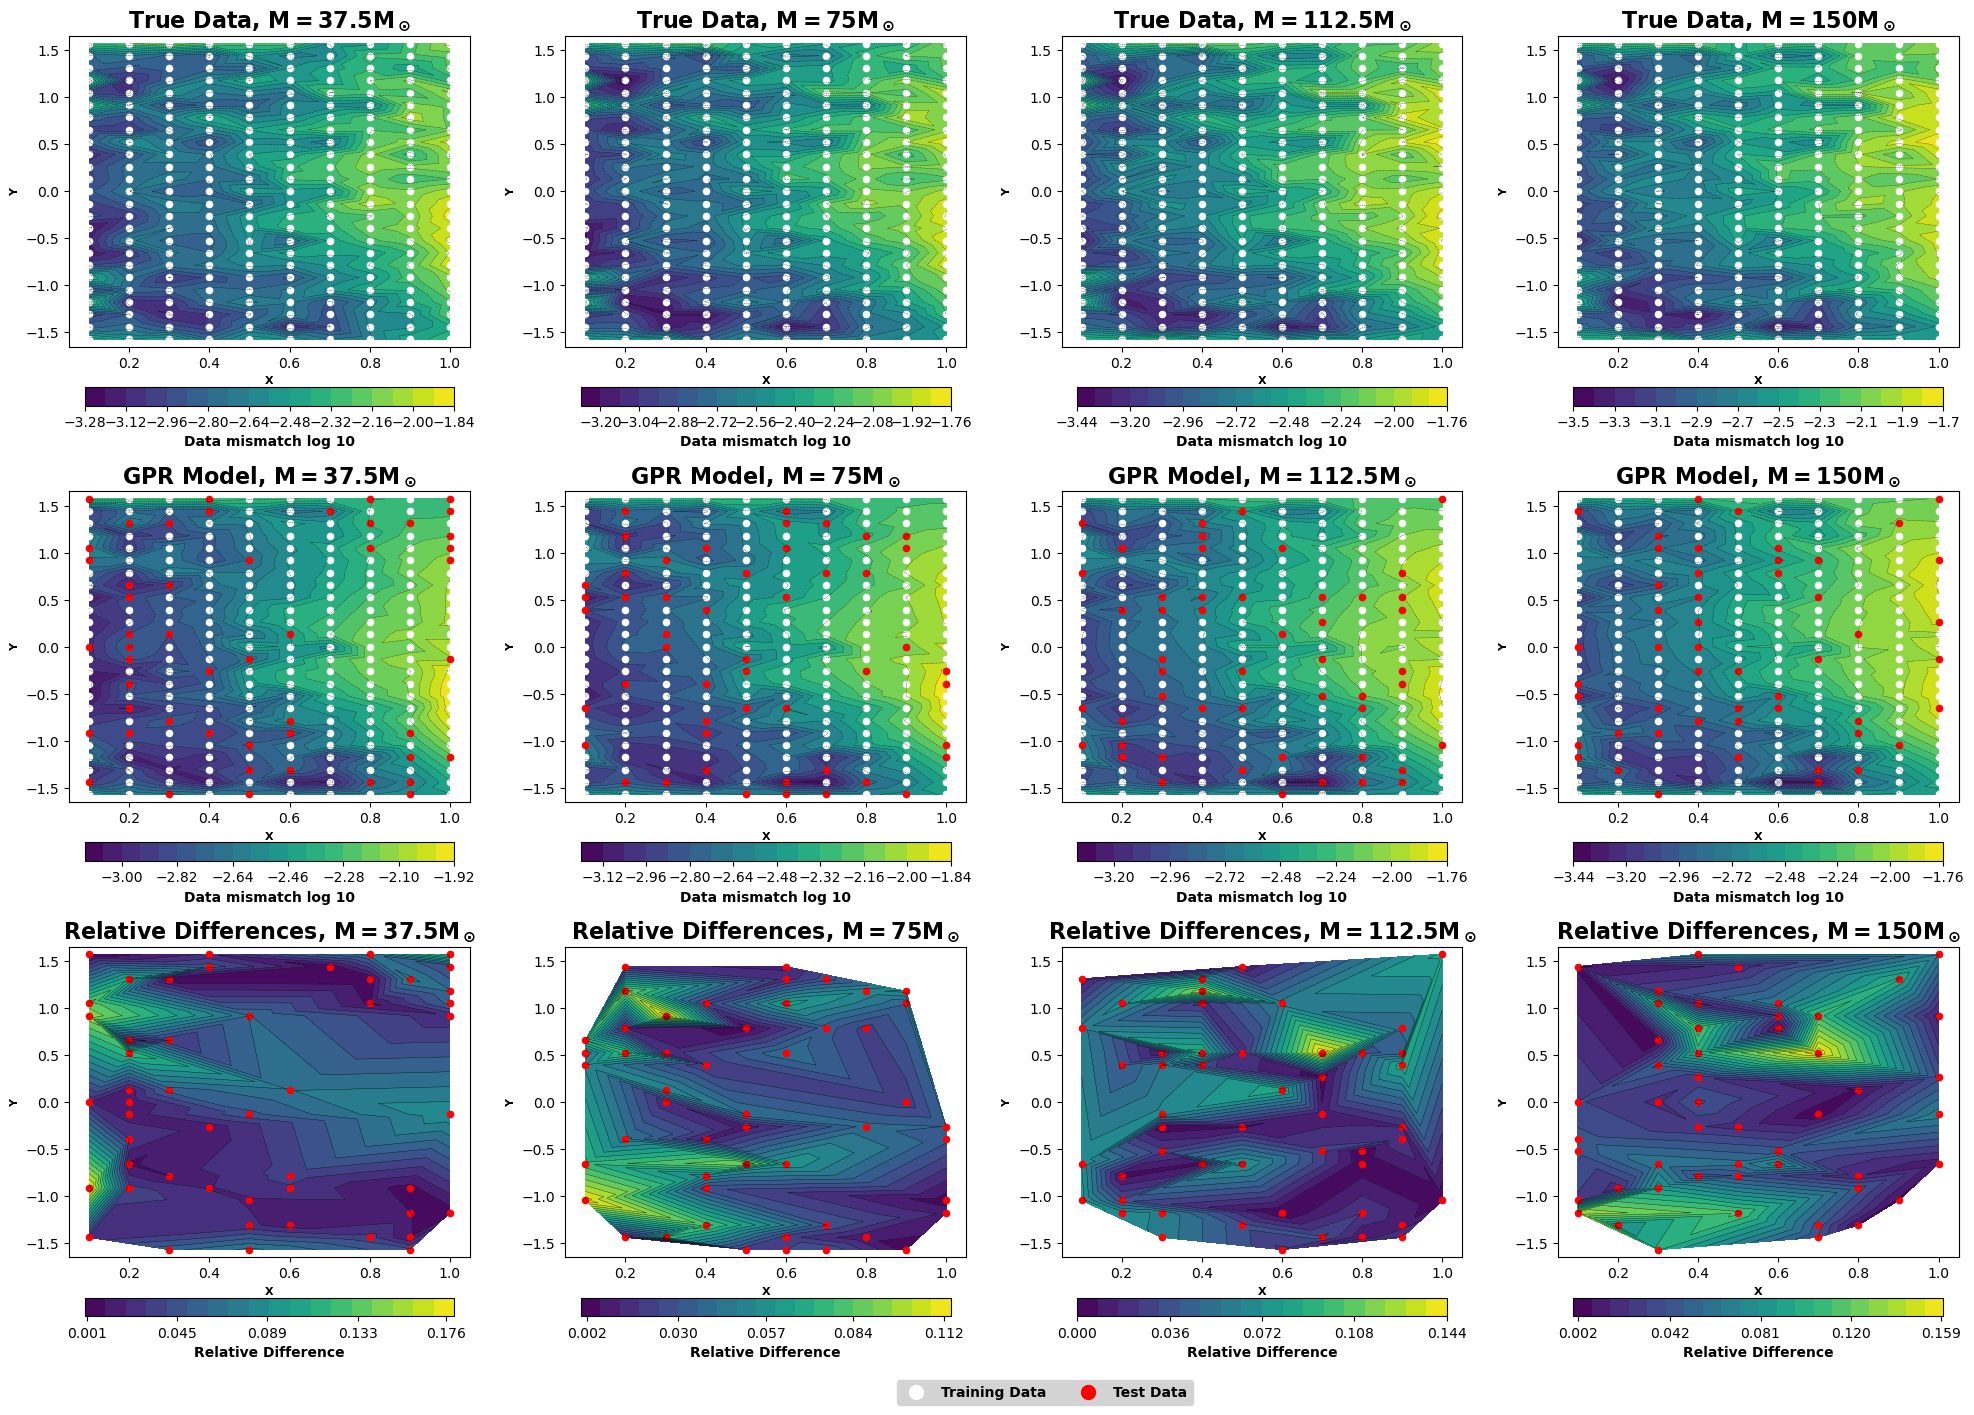

In [96]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Data
datasets = [
    (xm1, ym1, dm1, Dfit1, X1_train, X1_test, x_coords1, y_coords1, relative_difference1, r'$\mathbf{M = 37.5M_\odot}$'),
    (xm2, ym2, dm2, Dfit2, X2_train, X2_test, x_coords2, y_coords2, relative_difference2, r'$\mathbf{M = 75M_\odot}$'),
    (xm3, ym3, dm3, Dfit3, X3_train, X3_test, x_coords3, y_coords3, relative_difference3, r'$\mathbf{M = 112.5M_\odot}$'),
    (xm4, ym4, dm4, Dfit4, X4_train, X4_test, x_coords4, y_coords4, relative_difference4, r'$\mathbf{M = 150M_\odot}$'),
]


viridis_highcontrast = LinearSegmentedColormap.from_list("viridis_highcontrast", plt.cm.viridis(np.linspace(0, 1, 100)))



for col, (xm, ym, dm, Dfit, X_train, X_test, x_coords, y_coords, rel_diff, title) in enumerate(datasets):
    # Plot True Data
    contour1 = axes[0, col].tricontourf(xm, ym, dm, levels=20, cmap=viridis_highcontrast)
    axes[0, col].tricontour(xm, ym, dm, levels=20, colors='black', linewidths=0.25)
    axes[0, col].scatter(xm, ym, s=20,c='white')
    axes[0, col].set_xlim((0.05, 1.05))
    axes[0, col].set_ylim((-1.65, 1.65))
    axes[0, col].set_title(f'True Data, {title}', size=16, weight='bold')
    axes[0, col].set_xlabel('X', size=8, weight='bold')
    axes[0, col].set_ylabel('Y', size=8, weight='bold')
    cbar1 = fig.colorbar(contour1, ax=axes[0, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar1.set_label("Data mismatch log 10", size=10, weight='bold')
    #cbar1.set_ticks(np.around(np.linspace(dm.min(), dm.max(), 5), 1))  

    # Plot GPR Model
    contour2 = axes[1, col].tricontourf(xm, ym, Dfit, levels=20, cmap=viridis_highcontrast)
    axes[1, col].tricontour(xm, ym, Dfit, levels=20, colors='black', linewidths=0.25)
    axes[1, col].scatter(X_train[:, 0], X_train[:, 1], s=20,c='white', label='Train')
    axes[1, col].scatter(X_test[:, 0], X_test[:, 1], s=20,c='red', label='Test')
    axes[1, col].set_xlim((0.05, 1.05))
    axes[1, col].set_ylim((-1.65, 1.65))
    axes[1, col].set_title(f'GPR Model, {title}', size=16, weight='bold')
    axes[1, col].set_xlabel('X', size=8, weight='bold')
    axes[1, col].set_ylabel('Y', size=8, weight='bold')
    cbar2 = fig.colorbar(contour2, ax=axes[1, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar2.set_label("Data mismatch log 10", size=10, weight='bold')
    #cbar2.set_ticks(np.around(np.linspace(Dfit.min(), Dfit.max(), 5), 1)) 

    # Plot Relative Differences
    contour3 = axes[2, col].tricontourf(x_coords, y_coords, rel_diff, levels=20, cmap=viridis_highcontrast)
    axes[2, col].tricontour(x_coords, y_coords, rel_diff, levels=20, colors='black', linewidths=0.25)
    axes[2, col].scatter(x_coords, y_coords, s=20,c='red')
    axes[2, col].set_xlim((0.05, 1.05))
    axes[2, col].set_ylim((-1.65, 1.65))
    axes[2, col].set_title(f'Relative Differences, {title}', size=16, weight='bold')
    axes[2, col].set_xlabel('X', size=8, weight='bold')
    axes[2, col].set_ylabel('Y', size=8, weight='bold')
    cbar3 = fig.colorbar(contour3, ax=axes[2, col], orientation='horizontal', fraction=0.05, pad=0.11)
    cbar3.set_label("Relative Difference", size=10, weight='bold')
    cbar3.set_ticks(np.around(np.linspace(rel_diff.min(), rel_diff.max(), 5), 3))  


train_marker = mlines.Line2D([], [], color='white', marker='o', linestyle='None', markersize=10, label='Training Data')
test_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Test Data')


fig.legend(
    handles=[train_marker, test_marker],
    loc='lower center', 
    bbox_to_anchor=(0.525, -0.025),  
    ncol=2,
    markerscale=1,
    fontsize=28,
    frameon=True,  # Turn on the legend frame
    prop={'weight': 'bold'}
)

# Customize the legend background color
legend = fig.legends[0]  # Access the legend object
legend.get_frame().set_facecolor('lightgrey')  # Set the background color to grey
legend.get_frame().set_edgecolor('lightgrey')  # Optional: Add a black edge to the frame
legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)


plt.tight_layout(rect=[0, 0, 1, 0.92]) 
#plt.savefig("Real4ddata_with_legend", dpi=300, bbox_inches='tight')
plt.show()

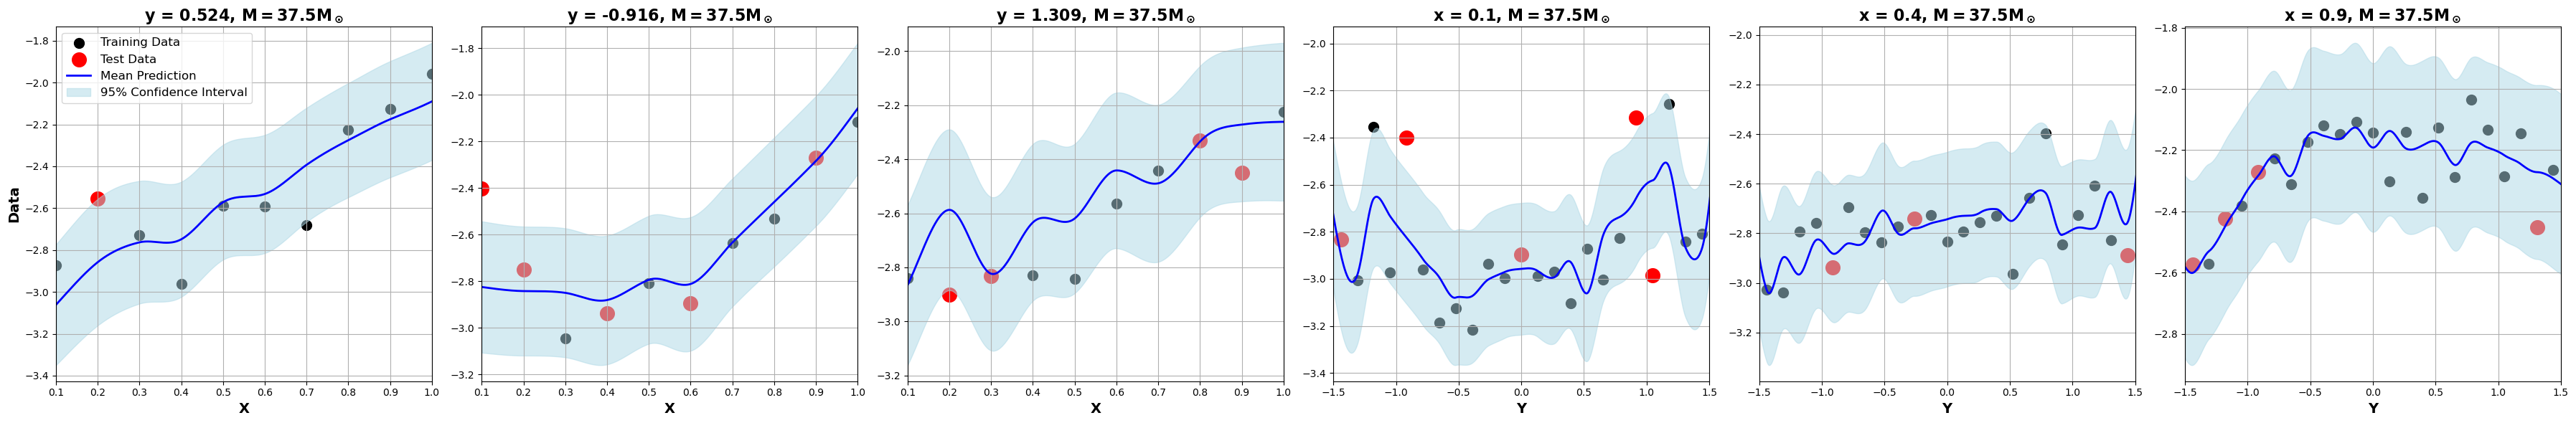

In [98]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 1000)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
# ypoints2 = np.array([-1.5707963267948966,
#     -1.4398966328953218, -1.3089969389957472, -1.1780972450961724, -1.0471975511965976,
#     -0.9162978572970231, -0.7853981633974483, -0.6544984694978736, -0.5235987755982988,
#     -0.39269908169872414, -0.2617993877991494, -0.1308996938995747, 0.0,
#      0.1308996938995747, 0.2617993877991494, 0.39269908169872414, 0.5235987755982988,
#      0.6544984694978736, 0.7853981633974483, 0.9162978572970231, 1.0471975511965976,
#      1.1780972450961724, 1.3089969389957472, 1.4398966328953218,1.5707963267948966])

ypoints2 = np.linspace(-1.5707963267948966,1.5707963267948966,1000)
xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]


fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=False)
j = 0

for i, ax in enumerate(axes):
    if (i<=2):
        ypoint = ypoints[i]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoints, ypoint), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoints, ypoint), method="cubic")
        indices1 = np.isclose(y1train,ypoints[i])
        indices2 = np.isclose(y1test,ypoints[i])
        ax.scatter(x1train[indices1],D1_train[indices1],s=100,color='black',label = 'Training Data')
        ax.scatter(x1test[indices2],D1_test[indices2],s=200,color='red',label = 'Test Data')
        ax.plot(xpoints, zgridlinear_mean,label='Mean Prediction', color='blue', linewidth=2)
        ax.fill_between(
            xpoints,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((0.1, 1))
        ax.set_xlabel('X', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
    else:
        xpoint = xpoints2[j]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoint, ypoints2), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoint, ypoints2), method="cubic")

        indices1 = np.isclose(x1train,xpoint)
        indices2 = np.isclose(x1test,xpoint)
        ax.scatter(y1train[indices1],D1_train[indices1],s=100,color='black',label = 'Training Data')
        ax.scatter(y1test[indices2],D1_test[indices2],s=200,color='red',label = 'Test Data')
        ax.plot(ypoints2, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=2)
        ax.fill_between(
            ypoints2,
            zgridlinear_mean - 2 * zgridlinear_std, 
            zgridlinear_mean + 2 * zgridlinear_std, 
            alpha=0.5,
            color='lightblue',
            label='95% Confidence Interval'
        )
        
        ax.set_xlim((-1.5, 1.5))
        ax.set_xlabel('Y', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
        j+=1
        
axes[0].set_ylabel('Data', fontsize=14, weight='bold')

axes[0].legend(fontsize=12,loc='upper left',frameon=True)
legend.get_frame().set_facecolor('white')  # Set the background color to grey
legend.get_frame().set_edgecolor('white')  # Optional: Add a black edge to the frame
legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)

#plt.savefig("crosscuts", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

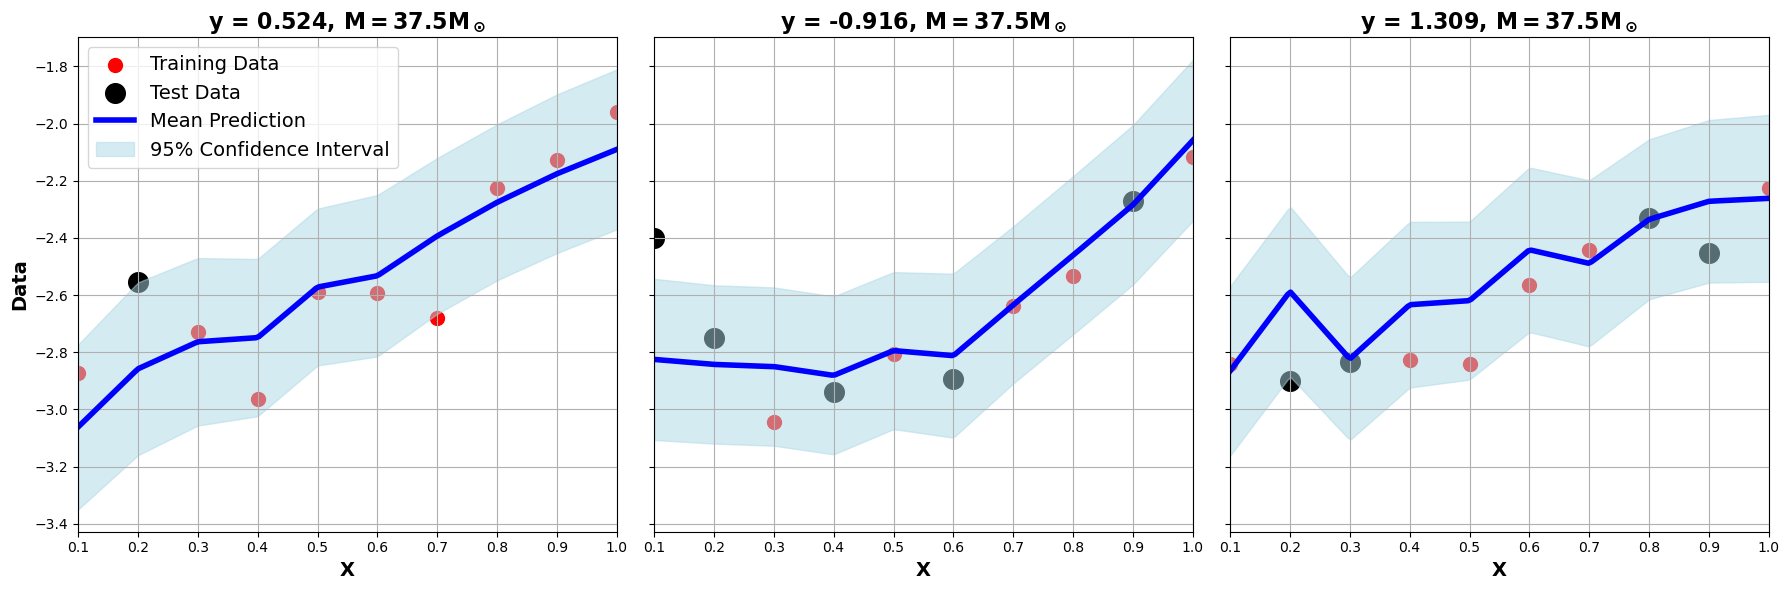

In [100]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 200)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.array([
    -1.4398966328953218, -1.3089969389957472, -1.1780972450961724, -1.0471975511965976,
    -0.9162978572970231, -0.7853981633974483, -0.6544984694978736, -0.5235987755982988,
    -0.39269908169872414, -0.2617993877991494, -0.1308996938995747, 0.0,
     0.1308996938995747, 0.2617993877991494, 0.39269908169872414, 0.5235987755982988,
     0.6544984694978736, 0.7853981633974483, 0.9162978572970231, 1.0471975511965976,
     1.1780972450961724, 1.3089969389957472, 1.4398966328953218
])

xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]



fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6), sharey=True)


for i, ax in enumerate(axes1):
    ypoint = ypoints[i]
    
    zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoints, ypoint), method="linear")
    zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoints, ypoint), method="linear")
    indices1 = np.isclose(y1train, ypoints[i])
    indices2 = np.isclose(y1test, ypoints[i])
    ax.scatter(x1train[indices1], D1_train[indices1], s=100,color='red', label='Training Data')
    ax.scatter(x1test[indices2], D1_test[indices2], s=200, color='black', label='Test Data')
    ax.plot(xpoints, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=4)
    ax.fill_between(
        xpoints,
        zgridlinear_mean - 2 * zgridlinear_std, 
        zgridlinear_mean + 2 * zgridlinear_std, 
        alpha=0.5,
        color='lightblue',
        label='95% Confidence Interval'
    )
    
    ax.set_xlim((0.1, 1))
    ax.set_xlabel('X', fontsize=14, weight='bold')
    ax.set_title(titles[i], fontsize=16, weight='bold')
    ax.grid(True)


axes1[0].set_ylabel('Data', fontsize=14, weight='bold')


axes1[0].legend(fontsize=14, loc='upper left')

plt.tight_layout()
plt.show()

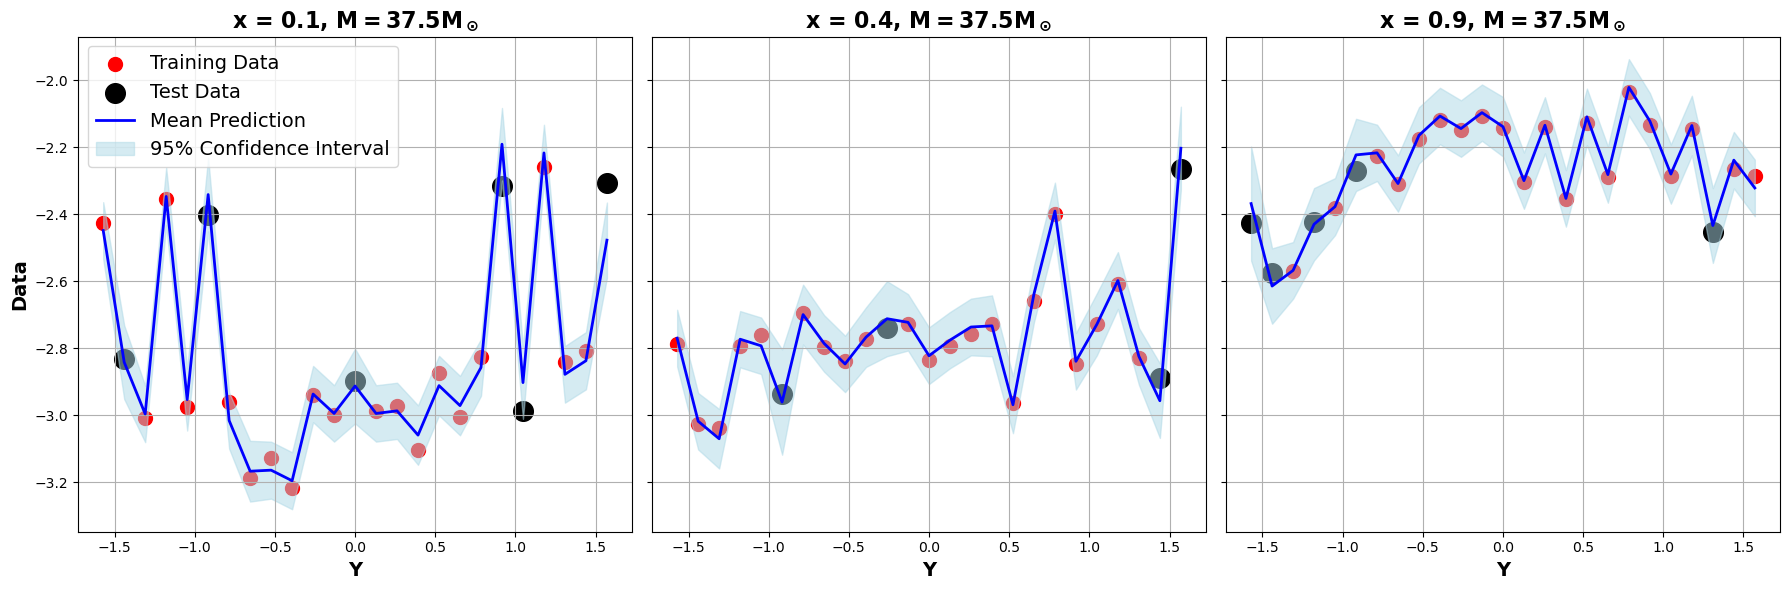

In [52]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 11)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.array([-1.5707963267948966,
    -1.4398966328953218, -1.3089969389957472, -1.1780972450961724, -1.0471975511965976,
    -0.9162978572970231, -0.7853981633974483, -0.6544984694978736, -0.5235987755982988,
    -0.39269908169872414, -0.2617993877991494, -0.1308996938995747, 0.0,
     0.1308996938995747, 0.2617993877991494, 0.39269908169872414, 0.5235987755982988,
     0.6544984694978736, 0.7853981633974483, 0.9162978572970231, 1.0471975511965976,
     1.1780972450961724, 1.3089969389957472, 1.4398966328953218,1.5707963267948966])

xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]


fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for j, ax in enumerate(axes2):
    xpoint = xpoints2[j]
    
    zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoint, ypoints2), method="linear")
    zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoint, ypoints2), method="linear")

    indices1 = np.isclose(x1train, xpoint)
    indices2 = np.isclose(x1test, xpoint)
    ax.scatter(y1train[indices1], D1_train[indices1], s=100,color='red', label='Training Data')
    ax.scatter(y1test[indices2], D1_test[indices2], s=200, color='black', label='Test Data')
    ax.plot(ypoints2, zgridlinear_mean, label='Mean Prediction', color='blue', linewidth=2)
    ax.fill_between(
        ypoints2,
        zgridlinear_mean - 2 * zgridlinear_std, 
        zgridlinear_mean + 2 * zgridlinear_std, 
        alpha=0.5,
        color='lightblue',
        label='95% Confidence Interval'
    )
    
    #ax.set_xlim((-1.5, 1.5))
    ax.set_xlabel('Y', fontsize=14, weight='bold')
    ax.set_title(titles[j + 3], fontsize=16, weight='bold')
    ax.grid(True)

axes2[0].set_ylabel('Data', fontsize=14, weight='bold')

axes2[0].legend(fontsize=14, loc='upper left')

plt.tight_layout()
plt.show()